In [ ]:
# 내 구글 드라이브에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
0 73.04%
2 99.87%
4 99.79%
=== process time 2.049 seconds


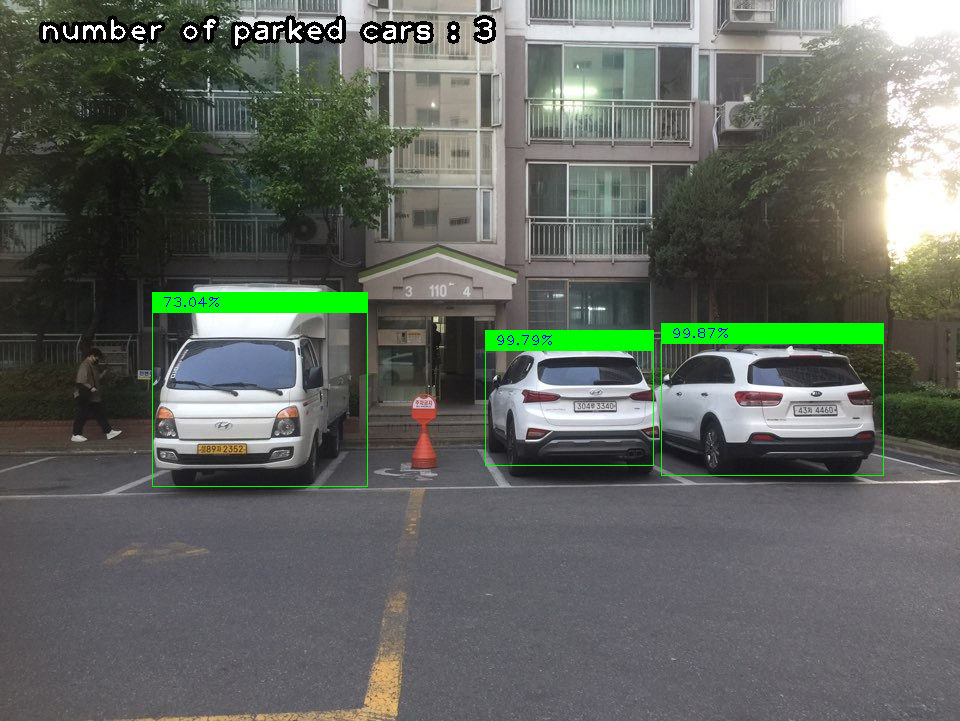

In [ ]:
# 필요한 패키지와 모듈을 불러온다.
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import time

min_confidence = 0.5  # detection 으로 인정할 최소 신뢰도(확률) 지정

file_nm = 'car1.jpg'  # 원본 이미지
file_name = "gdrive/My Drive/CV/Parking Car Count/image/" + file_nm
yolov3_weights = "gdrive/My Drive/CV/Object Detection_YOLO/yolov3.weights"
yolov3_cfg = "gdrive/My Drive/CV/Object Detection_YOLO/yolov3.cfg"
coco_names = "gdrive/My Drive/CV/Object Detection_YOLO/coco.names"

# Load Yolo
net = cv2.dnn.readNet(yolov3_weights, yolov3_cfg)
classes = []  # detection 할 Object(Class) list 배열을 정의

with open(coco_names, "r") as f:
    classes = [line.strip() for line in f.readlines()]  # 80개의 Object(class)를 구분할 수 있는 Object의 이름을 classes 배열에 넣어준다.

print(classes)

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Loading image
start_time = time.time()
img = cv2.imread(file_name)  # 원본이미지를 읽어 옵니다
height, width, channels = img.shape

# Detecting objects
# YOLOv3의 Detecting model 3가지(320×320, 416×416, 608×608)
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

net.setInput(blob)
outs = net.forward(output_layers)

# Showing informations on the screen
confidences = []   # detection 한 Class 의 신뢰도(확률)를 저장하는 배열 정의
boxes = []         # detection 한 boxing 정보를 저장하는 배열 정의 

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)     # detection 한 Class id
        confidence = scores[class_id]    # detection 한 Class 의 신뢰도(확률)
        # Filter only 'car'
        if class_id == 2 and confidence > min_confidence:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])             # boxing 정보를 boxes 배열에 저장
            confidences.append(float(confidence))  # 신뢰도(확률)을 confidences 배열에 저장

# apply non-max suppression
indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)  # 박스안에 박스(노이즈)를 하나로 만들어 준다.

for i in range(len(boxes)):
    if i in indexes:      # 노이즈가 제거된 박스만 표시해 준다.
        x, y, w, h = boxes[i]
        label = '{:,.2%}'.format(confidences[i])  # 신뢰도(확률)
        print(i, label)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
        cv2.rectangle(img, (x, y - 20), (x + w, y), (0, 255, 0), -1)
        cv2.putText(img, label, (x + 10, y - 5), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 1)
        
text = "number of parked cars : {} ".format(len(indexes))
cv2.putText(img, text, (40, 40), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 10)
cv2.putText(img, text, (40, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)

process_time = time.time() - start_time
print("=== process time {:.3f} seconds".format(process_time))

cv2_imshow(img)